## Self Normalizing Networks (SNN) w/ Scaled Exponential Linear Units (SELU)

    1. Gradient issues
    2. Normalization/Standardization
    3. Weight Normalization
    4. Batch Normalization
    5. Layer Normalization
    6. Self Normalizing Networks (SNN)
    7. Scaled Exponential Linear Units (SELU)
    8. Implementation
    9. Additional Resources

In [1]:
import os
import sys
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from pycrayon import (
    CrayonClient,
)

from IPython import (
    display,
)

from IPython.display import (
    Image,
    clear_output,
)

# get matplotlib configuration
%matplotlib inline
%run plot_conf.py

In [2]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import (
    Variable,
)

from torch.nn import (
    init,
)

from torchvision import (
    datasets, 
    transforms,
    models,
    utils,
)

Adding MATERIALS for NLPWP (may include selu stuff with it)
No GPU used b/c of book standards and can't access it one this Key...

### 8. Implementation

```bash
Self-Normalizing Neural Networks
Günter Klambauer, Thomas Unterthiner, Andreas Mayr, Sepp Hochreiter
https://arxiv.org/abs/1706.02515
```

**Caution:** Not an official implementation. There going to be a lot of overfitting, etc. Just wanted to see how SELU works but MNIST isn't giving great insight ... I'll explore some more interesting tasks and use deeper models later.

#### Data

In [10]:
batch_size = 100

In [11]:
# Train data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

# Test data loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

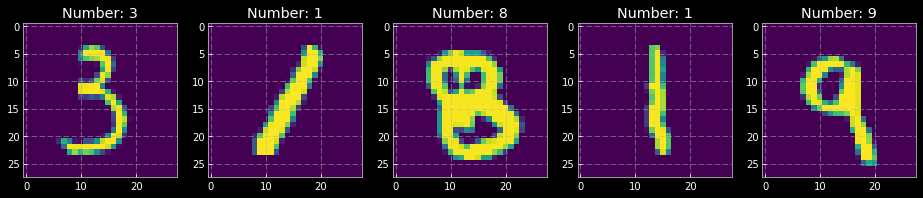

In [12]:
# Visualize some samples
for batch in test_loader:
    samples = batch[0][:5]
    y_true = batch[1]
    plt.subplot(1, 5, 1)
    for i, sample in enumerate(samples):
        plt.subplot(1, 5, i+1)
        plt.title('Number: %i'% y_true[i])
        plt.imshow(sample.numpy().reshape((28,28)))
    break

#### Training functions

In [13]:
def process_batch(inputs, targets, model, criterion, optimizer, cuda, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    
    if cuda:
        inputs, target = inputs.cuda(), target.cuda()
    
    # Convert tensors to Variables (for autograd)
    if is_training:
        X_batch = Variable(inputs, requires_grad=False)
    else:
        X_batch = Variable(inputs, volatile=True, requires_grad=False)
    y_batch = Variable(targets.long(), requires_grad=False)
    
    # Forward pass
    activations, scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradient norms
        nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy, activations

In [29]:
def train(exp, exp_name, model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda):
    """
    Training.
    """
    
    # Metrics
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (inputs, target) in enumerate(train_loader):
           
            if exp_name.split("_")[-1] == "mlp":
                # Flatten inputs to feed into MLP
                inputs = inputs.view(len(inputs), -1)

            # Get metrics
            model.train()
            loss, accuracy, activations = process_batch(inputs, target, model, criterion, optimizer, cuda, model.training)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(inputs))
            train_batch_accuracy += accuracy
                        
            # Collect activations
            for activation_num, activation in enumerate(activations):
                exp.add_histogram_value(
                    "z%i"%(activation_num+1), hist=list(activation.data.view(-1, )), tobuild=True)
            
            # Record metrics
            exp.add_scalar_value("train_loss", value=loss.data[0] / float(len(inputs)))
            exp.add_scalar_value("train_accuracy", value=accuracy)
            
        # Add to global metrics
        train_loss.append(train_batch_loss/float(train_batch_num+1))
        train_acc.append(train_batch_accuracy/float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):

            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0

            for test_batch_num, (inputs, target) in enumerate(test_loader):
                
                if exp_name.split("_")[-1] == "mlp":
                    # Flatten inputs to feed into MLP
                    inputs = inputs.view(len(inputs), -1)

                # Get metrics
                model.eval()
                loss, accuracy, activations = \
                    process_batch(inputs, target, model, criterion, optimizer, cuda, model.training)

                # Add to batch scalars
                test_batch_loss += loss.data[0] / float(len(inputs))
                test_batch_accuracy += accuracy
                
                # Record metrics
                exp.add_scalar_value("test_loss", value=loss.data[0] / float(len(inputs)))
                exp.add_scalar_value("test_accuracy", value=accuracy)

            # Add to global metrics
            test_loss.append(test_batch_loss/float(test_batch_num+1))
            test_acc.append(test_batch_accuracy/float(test_batch_num+1))
                

            verbose_condition = \
                (num_train_epoch == 0) or (num_train_epoch % log_interval == 0) or (num_train_epoch == num_epochs-1)

            # Verbose
            if verbose_condition:

                # Verbose
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
                minutes = time_remain // 60
                seconds = time_remain - minutes*60
                print("TIME REMAINING: %im %is" % (minutes, seconds))
                print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                       (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                        train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                        test_batch_accuracy/float(test_batch_num+1)))
    
    return model

#### Set up Crayon

In [15]:
# Connect to the server for Crayon (tensorboard)
cc = CrayonClient(hostname="localhost", port=8889)

### MLP

In [16]:
# training params
num_epochs = 3
learning_rate = 1e-3
dropout_p = 0.05
log_interval = 1 # epochs
num_hidden_units = 100
num_classes = 10 # MNIST
decay_rate = 0.9999
max_grad_norm = 5.0

# Use gpu
cuda = True
cuda = cuda and torch.cuda.is_available()

# reproduceability
seed = 1234
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

#### ReLU model

In [17]:
# Create relu experiment
exp_name = "relu_mlp"
try:
    cc.remove_experiment(exp_name)
    exp = cc.create_experiment(exp_name)
except:
    exp = cc.create_experiment(exp_name)

In [18]:
class relu_mlp(nn.Module):
    """
    Simple MLP with ReLU non-linearities.
    """
    def __init__(self, num_hidden_units, num_classes):
        """
        Initialization.
        """
        super(relu_mlp, self).__init__()
        self.fc1 = nn.Linear(784, num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_hidden_units)
        self.fc3 = nn.Linear(num_hidden_units, num_classes)
        
        self.init_weights()
        
    def init_weights(self):
        """
        Properly initialize weights.
        """
        init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2.0)) # gain for ReLU
        init.xavier_uniform(self.fc2.weight, gain=np.sqrt(2.0)) # gain for ReLU
        
    def forward(self, x):
        """
        Feed forward.
        """
        z1 = F.relu(self.fc1(x))
        z2 = F.relu(self.fc2(z1))
        z3 = self.fc3(z2)
        return [z1, z2, z3], z3

In [19]:
# Initialize model components
model = relu_mlp(num_hidden_units, num_classes)
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
model = train(exp, exp_name, model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda)

TIME REMAINING: 1m 35s
[EPOCH]: 0, [TRAIN LOSS]: 0.002720, [TRAIN ACC]: 0.919, [TEST LOSS]: 0.001336, [TEST ACC]: 0.958
TIME REMAINING: 0m 46s
[EPOCH]: 1, [TRAIN LOSS]: 0.001132, [TRAIN ACC]: 0.966, [TEST LOSS]: 0.001081, [TEST ACC]: 0.967
TIME REMAINING: 0m 0s
[EPOCH]: 2, [TRAIN LOSS]: 0.000781, [TRAIN ACC]: 0.976, [TEST LOSS]: 0.000921, [TEST ACC]: 0.972


#### SELU model

In [20]:
# Create relu experiment
exp_name = "selu_mlp"
try:
    cc.remove_experiment(exp_name)
    exp = cc.create_experiment(exp_name)
except:
    exp = cc.create_experiment(exp_name)

In [21]:
def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * F.elu(x, alpha)

In [22]:
class selu_mlp(nn.Module):
    """
    Simple MLP with ReLU non-linearities.
    """
    def __init__(self, num_hidden_units, num_classes):
        """
        Initialization.
        """
        super(selu_mlp, self).__init__()
        self.fc1 = nn.Linear(784, num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_hidden_units)
        self.fc3 = nn.Linear(num_hidden_units, num_classes)
        
        self.init_weights()

    def init_weights(self):
        """
        Properly initialize weights from a gaussian distribution w/ mean=0 and var=1/n
        """
        # weights
        self.fc1.weight.data.normal_(mean=0, std=np.sqrt(1/len(self.fc1.weight.data[0])))
        self.fc2.weight.data.normal_(mean=0, std=np.sqrt(1/len(self.fc2.weight.data[0])))
        self.fc3.weight.data.normal_(mean=0, std=np.sqrt(1/len(self.fc3.weight.data[0])))
        
        # biases
        self.fc1.bias.data.normal_(mean=0, std=0.1)
        self.fc2.bias.data.normal_(mean=0, std=0.1)
        self.fc3.bias.data.normal_(mean=0, std=0.1)
        
    def forward(self, x):
        """
        Feed forward.
        """
        z1 = selu(self.fc1(x))
        z2 = selu(self.fc2(z1))
        z3 = self.fc3(z2)
        return [z1, z2, z3], z3

In [23]:
# Initialize model components
model = selu_mlp(num_hidden_units, num_classes)
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
model = train(exp, exp_name, model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda)

TIME REMAINING: 1m 52s
[EPOCH]: 0, [TRAIN LOSS]: 0.002625, [TRAIN ACC]: 0.920, [TEST LOSS]: 0.001453, [TEST ACC]: 0.957
TIME REMAINING: 0m 55s
[EPOCH]: 1, [TRAIN LOSS]: 0.001183, [TRAIN ACC]: 0.964, [TEST LOSS]: 0.001094, [TEST ACC]: 0.965
TIME REMAINING: 0m 0s
[EPOCH]: 2, [TRAIN LOSS]: 0.000826, [TRAIN ACC]: 0.975, [TEST LOSS]: 0.000930, [TEST ACC]: 0.970


<img src="figures/key_mlp.png"></img>
<img src="figures/activations_mlp.png"></img>
<img src="figures/train_acc_mlp.png"></img>

### CNN

In [30]:
# training params
num_epochs = 3
learning_rate = 0.01
dropout_p = 0.5
log_interval = 1 # epochs
num_hidden_units = 100
num_classes = 10 # MNIST
decay_rate = 0.9999
max_grad_norm = 5.0

# Use gpu
cuda = True
cuda = cuda and torch.cuda.is_available()

# reproduceability
seed = 1234
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

#### ReLU CNN

In [31]:
# Create relu experiment
exp_name = "relu_cnn"
try:
    cc.remove_experiment(exp_name)
    exp = cc.create_experiment(exp_name)
except:
    exp = cc.create_experiment(exp_name)

In [32]:
# CNN model
class relu_cnn(nn.Module):
    """
    Simple CNN for MNIST classification.
    """
    def __init__(self, dropout_p, num_hidden_units, num_classes):
        """
        Initialization.
        """
        super(relu_cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout_conv2 = nn.Dropout2d(dropout_p)
        self.fc1 = nn.Linear(320, num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_classes)
        
        self.init_weights()
        
    def init_weights(self):
        """
        Properly initialize weights.
        """
        init.xavier_uniform(self.conv1.weight, gain=np.sqrt(2.0)) # gain for ReLU
        init.xavier_uniform(self.conv2.weight, gain=np.sqrt(2.0)) # gain for ReLU
        init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2.0)) # gain for ReLU

    def forward(self, x):
        """
        Feed Foward.
        """
        z1 = F.relu(F.max_pool2d(self.conv1(x), 2))
        z2 = F.relu(F.max_pool2d(self.dropout_conv2(self.conv2(z1)), 2))
        z2 = z2.view(-1, 320) # flatten
        z3 = F.relu(self.fc1(z2))
        z4 = F.dropout(z3, training=self.training)
        z5 = self.fc2(z4)
        return [z1, z2, z3, z4, z5], z5

In [33]:
# Initialize model components
model = relu_cnn(dropout_p, num_hidden_units, num_classes)
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [34]:
model = train(exp, exp_name, model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda)

TIME REMAINING: 7m 38s
[EPOCH]: 0, [TRAIN LOSS]: 0.007336, [TRAIN ACC]: 0.758, [TEST LOSS]: 0.001445, [TEST ACC]: 0.955
TIME REMAINING: 3m 31s
[EPOCH]: 1, [TRAIN LOSS]: 0.004509, [TRAIN ACC]: 0.862, [TEST LOSS]: 0.001250, [TEST ACC]: 0.963
TIME REMAINING: 0m 0s
[EPOCH]: 2, [TRAIN LOSS]: 0.004265, [TRAIN ACC]: 0.873, [TEST LOSS]: 0.001448, [TEST ACC]: 0.959


#### SELU CNN

In [35]:
dropout_p = 0.0 # keep 0 until implemented alpha dropout

In [36]:
# Create relu experiment
exp_name = "selu_cnn"
try:
    cc.remove_experiment(exp_name)
    exp = cc.create_experiment(exp_name)
except:
    exp = cc.create_experiment(exp_name)

In [37]:
# CNN model
class selu_cnn(nn.Module):
    """
    Simple CNN for MNIST classification.
    """
    def __init__(self, dropout_p, num_hidden_units, num_classes):
        """
        Initialization.
        """
        super(selu_cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout_conv2 = nn.Dropout2d(dropout_p)
        self.fc1 = nn.Linear(320, num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_classes)
        
        self.init_weights()
        
    def init_weights(self):
        """
        Properly initialize weights from a gaussian distribution w/ mean=0 and var=1/n
        """
        
        def get_conv_fan_in_size(weight):
            """
            Get the fan_in dimension for conv weights.
            """
            size = weight.data.size()
            return size[0]*size[1]*size[2]
                    
        # weights
        self.conv1.weight.data.normal_(mean=0, std=np.sqrt(1/get_conv_fan_in_size(self.conv1.weight)))
        self.conv2.weight.data.normal_(mean=0, std=np.sqrt(1/get_conv_fan_in_size(self.conv2.weight)))
        self.fc1.weight.data.normal_(mean=0, std=np.sqrt(1/len(self.fc1.weight.data[0])))
        
        # biases
        self.conv1.bias.data.normal_(mean=0, std=0.1)
        self.conv2.bias.data.normal_(mean=0, std=0.1)
        self.fc1.bias.data.normal_(mean=0, std=0.1)

    def forward(self, x):
        """
        Feed Foward.
        """
        z1 = selu(F.max_pool2d(self.conv1(x), 2))
        z2 = selu(F.max_pool2d(self.dropout_conv2(self.conv2(z1)), 2))
        z2 = z2.view(-1, 320) # flatten
        z3 = selu(self.fc1(z2))
        z4 = F.dropout(z3, training=self.training)
        z5 = self.fc2(z4)
        return [z1, z2, z3, z4, z5], z5

In [38]:
# Initialize model components
model = selu_cnn(dropout_p, num_hidden_units, num_classes)
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [39]:
model = train(exp, exp_name, model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda)

TIME REMAINING: 10m 32s
[EPOCH]: 0, [TRAIN LOSS]: 0.003927, [TRAIN ACC]: 0.909, [TEST LOSS]: 0.001677, [TEST ACC]: 0.971
TIME REMAINING: 5m 17s
[EPOCH]: 1, [TRAIN LOSS]: 0.003354, [TRAIN ACC]: 0.935, [TEST LOSS]: 0.001636, [TEST ACC]: 0.969
TIME REMAINING: 0m 0s
[EPOCH]: 2, [TRAIN LOSS]: 0.003347, [TRAIN ACC]: 0.939, [TEST LOSS]: 0.001347, [TEST ACC]: 0.971


<img src="figures/key_cnn.png"></img>
<img src="figures/activations_cnn.png"></img>
<img src="figures/train_acc_cnn.png"></img>

#### Alpha dropout

In [69]:
dropout_p = 0.05

In [70]:
# Create relu experiment
exp_name = "selu_cnn_alpha_dropout"
try:
    cc.remove_experiment(exp_name)
    exp = cc.create_experiment(exp_name)
except:
    exp = cc.create_experiment(exp_name)

$$ q = \text{keep_prob, } d = W_{binomial} \text{ for dropout mask} $$
$$ E(x) = \mu, Var(x) = v $$
$$ $$ 
$$ \text{w/ dropout with ReLU} (x \rightarrow -\infty, y=0) $$
$$ \text{After dropout our activations will not be } xd + 0(1-d) $$
$$ \text{We need to scale this so that we maintain mean=0 and var=1} $$
$$ \text{So, we need to scale the activations (after dropout) by } \frac{1}{q} $$
$$ $$
$$ \text{w/ dropout with SELU} (x \rightarrow -\infty, y=-\lambda\alpha = \alpha^{'}) $$
$$ \text{applying dropout here is randomly setting activations to } \alpha^{'} \text{ value (instead of zero)} $$
$$ \text{After dropout our activations will not be } xd + \alpha^{'}(1-d) $$
$$ E(xd + \alpha^{'}(1-d)) =  q\mu + (1-q)alpha^{'} $$
$$ Var(xd + \alpha^{'}(1-d)) = q((1-q)(\alpha^{'}-\mu)^2+v) $$
$$ \text{We need scale these activations using scale factors a and b: } a(xd + \alpha^{'}(1-d)) + b $$
$$ E(a(xd + \alpha^{'}(1-d)) + b) = \mu $$
$$ Var(a(xd + \alpha^{'}(1-d)) + b) = v $$
$$ \text{ for } \mu=0 \text{ and } v=1: a = (q + {\alpha^{'}}^{2} q(1-q))^{-0.5}, b = -(q+ {\alpha^{'}}^{2} q(1-q))^{-0.5}((1-q)\alpha^{'}) $$

In [71]:
class alpha_dropout(nn.Module):
    """
    Alpha dropout to use during training
    in order to scale the activations so
    we maintain desired mean and var.
    """
    # -1.7580993408473766 = - scale * alpha = limit of selu as x --> -inf
    def __init__(self, dropout_p, alpha_prime=-1.7580993408473766, mean=0, var=1):
        """
        Initialization
        """
        super(alpha_dropout, self).__init__()
        self.alpha_prime = alpha_prime
        self.q = 1-dropout_p # keep_prob
        self.a = 1.0 / np.sqrt( self.q + (self.alpha_prime**2) * self.q * (1-self.q) )
        self.b = -1.0 * \
                ( 1.0 / np.sqrt( self.q + self.alpha_prime * self.q * (1-self.q))) * \
                ((1-self.q) * self.alpha_prime)
        
    def forward(self, x):
        """
        Forward pass.
        """
        if self.q == 1.0 or not self.training:
            return x # no dropout
        else:
            dropout_mask = Variable(torch.Tensor(x.size()).fill_(self.q).bernoulli_())
            activations = x.mul(dropout_mask) + self.alpha_prime * (1-dropout_mask)
            activations.mul_(self.a).add_(self.b)
            return activations

In [72]:
# CNN model
class selu_cnn_alpha_dropout(nn.Module):
    """
    Simple CNN for MNIST classification.
    """
    def __init__(self, dropout_p, num_hidden_units, num_classes):
        """
        Initialization.
        """
        super(selu_cnn_alpha_dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout_conv2 = alpha_dropout(0.05)
        self.fc1 = nn.Linear(320, num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_classes)
        
        self.init_weights()
        
    def init_weights(self):
        """
        Properly initialize weights from a gaussian distribution w/ mean=0 and var=1/n
        """
        
        def get_conv_fan_in_size(weight):
            """
            Get the fan_in dimension for conv weights.
            """
            size = weight.data.size()
            return size[0]*size[1]*size[2]
                    
        # weights
        self.conv1.weight.data.normal_(mean=0, std=np.sqrt(1/get_conv_fan_in_size(self.conv1.weight)))
        self.conv2.weight.data.normal_(mean=0, std=np.sqrt(1/get_conv_fan_in_size(self.conv2.weight)))
        self.fc1.weight.data.normal_(mean=0, std=np.sqrt(1/len(self.fc1.weight.data[0])))
        
        # biases
        self.conv1.bias.data.normal_(mean=0, std=0.1)
        self.conv2.bias.data.normal_(mean=0, std=0.1)
        self.fc1.bias.data.normal_(mean=0, std=0.1)

    def forward(self, x):
        """
        Feed Foward.
        """
        z1 = selu(F.max_pool2d(self.conv1(x), 2))
        z2 = selu(F.max_pool2d(self.dropout_conv2(self.conv2(z1)), 2))
        z2 = z2.view(-1, 320) # flatten
        z3 = selu(self.fc1(z2))
        z4 = F.dropout(z3, training=self.training)
        z5 = self.fc2(z4)
        return [z1, z2, z3, z4, z5], z5

In [73]:
# Initialize model components
model = selu_cnn_alpha_dropout(dropout_p, num_hidden_units, num_classes)
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [74]:
model = train(exp, exp_name, model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda)

TIME REMAINING: 11m 28s
[EPOCH]: 0, [TRAIN LOSS]: 0.004308, [TRAIN ACC]: 0.891, [TEST LOSS]: 0.001625, [TEST ACC]: 0.964
TIME REMAINING: 5m 41s
[EPOCH]: 1, [TRAIN LOSS]: 0.003909, [TRAIN ACC]: 0.916, [TEST LOSS]: 0.001855, [TEST ACC]: 0.973
TIME REMAINING: 0m 0s
[EPOCH]: 2, [TRAIN LOSS]: 0.003645, [TRAIN ACC]: 0.927, [TEST LOSS]: 0.001292, [TEST ACC]: 0.976


<img src="figures/key_dropout.png"></img>
<img src="figures/activations_dropout.png"></img>
<img src="figures/activations_dropout_2.png"></img>

# ...

### Additional Resources (not my code)

If you want to know the scaling and alpha values for any arbitrary fixed point mean and variance, use this code by the authors. Credit: https://github.com/bioinf-jku/SNNs/blob/master/getSELUparameters.ipynb

In [77]:
import numpy as np
from scipy.special import erf,erfc
from sympy import Symbol, solve, nsolve

In [79]:
def getSeluParameters(fixedpointMean=0, fixedpointVar=1):
    """ 
    Finding the parameters of the 
    SELU activation function. The 
    function returns alpha and lambda 
    for the desired fixed point. 
    """
    
    import sympy
    from sympy import Symbol, solve, nsolve

    aa = Symbol('aa')
    ll = Symbol('ll')
    nu = fixedpointMean 
    tau = fixedpointVar 

    mean =  0.5*ll*(nu + np.exp(-nu**2/(2*tau))*np.sqrt(2/np.pi)*np.sqrt(tau) + \
                        nu*erf(nu/(np.sqrt(2*tau))) - aa*erfc(nu/(np.sqrt(2*tau))) + \
                        np.exp(nu+tau/2)*aa*erfc((nu+tau)/(np.sqrt(2*tau))))

    var = 0.5*ll**2*(np.exp(-nu**2/(2*tau))*np.sqrt(2/np.pi*tau)*nu + (nu**2+tau)* \
                          (1+erf(nu/(np.sqrt(2*tau)))) + aa**2 *erfc(nu/(np.sqrt(2*tau))) \
                          - aa**2 * 2 *np.exp(nu+tau/2)*erfc((nu+tau)/(np.sqrt(2*tau)))+ \
                          aa**2*np.exp(2*(nu+tau))*erfc((nu+2*tau)/(np.sqrt(2*tau))) ) - mean**2

    eq1 = mean - nu
    eq2 = var - tau

    res = nsolve( (eq2, eq1), (aa,ll), (1.67,1.05))
    return float(res[0]),float(res[1])

In [82]:
print (getSeluParameters(fixedpointMean=0, fixedpointVar=1))
print (getSeluParameters(fixedpointMean=0.1, fixedpointVar=2.0))

(1.6732632423543774, 1.0507009873554802)
(1.9622211815386628, 1.0498194717277889)


# ...